# Introduction
This notebook contains an analysis comparing the living wage to the wages of various agricultural occupations. Comparing the living wage to the wage earned by agricultural occupations is one way to view the economic landscape of farming. Ideally, farmers should be earning at least the living wage. This analysis can help determine this information and identify those most in need of assistance.

In [0]:
import pandas as pd
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import  urljoin
import matplotlib.pyplot as plt
import requests, json

# Living Wage Data

The first step in this analysis is to obtain the living wage data. The living wage is a more refined version of the federal poverty threshold. The federal poverty threshold does not account for the living costs beyond a basic food budget. In contrast, the living wage draws upon geographically specific expenditure data related to a family’s likely minimum food, childcare, health insurance, housing, transportation, and other basic necessities. 

MIT's Dr. Amy Glasmeier created a [living wage calculator](https://http://livingwage.mit.edu/) in 2004 that determines the living wage at the county, state, and national level for various living situations. This is a very valuable resource. Unfortunately, the data that this calculator provides is not in a very accessible format for large scale analysis. The data for each state is each on a different page so it would take a long time to collect all of the data. Instead, we will politely scrape the data from this website. Please do not abuse the following code and overload this valuable resource. 



In [0]:
#This scrapes all the first numeric row from the first table on each states page
base = "http://livingwage.mit.edu"
res = requests.get(base)

res.raise_for_status()
states = []

#Collects all the state urls and names and stores them as a tuple in states list.

for a in BeautifulSoup(res.text, "html.parser").select("ul.states.list-unstyled li a"):
    #Use rsplit() to select everything to the right of /locations
    #Go from .../states/51/locations to /states/51
      states.append((urljoin(base, a["href"].rsplit("/", 1)[0]), a.text))
      
def parse(soup):
    #Indexing in css starts at 1, so table:nth-of-type(1)" gets the first table.
    table = soup.select_one("table:nth-of-type(1)")
    # To get the text, we just need find all the tds and call .text on each.
    #  Each td we want has the css class "odd results", td + td starts from the second as we don't want the first.
    return [td.text.strip() for td in table.select_one("tr.odd.results").select("td + td")]

# Unpack the url and state from each tuple in our states list.
state_dict = {}
for url, state in states:
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    state_dict[state] = parse(soup)
    #Could use this next line to track progress. Supressed for formatting.
    #print(state, parse(soup))
    
    #Rest between requests to not overload website
    time.sleep(2)

**Now we can convert the dictionary into a dataframe.**

In [22]:
#State Level Living wages dict to df conversion

#Convert dictionary to df
df = pd.DataFrame.from_dict(state_dict)

#Add the various classifications as the index
names = ['1 Adult', '1 Adult 1 Child', '1 Adult 2 Children', '1 Adult 3 Children', '2 Adults (1 Working)', 
         '2 Adults (1 Working) 1 Child', '2 Adults (1 Working) 2 Children', '2 Adults (1 Working) 3 Children', 
         '2 Adults (1 Working Part Time) 1 Child*', '2 Adults', '2 Adults 1 Child', '2 Adults 2 Children', '2 Adults 3 Children']
df['Classification'] = names
df = df.set_index('Classification')

#Remove $ and convert to float
df = df[df.columns[:]].replace('[\$,]', '', regex=True).astype(float)

#Transpose
df = df.transpose()

#Save as csv to avoid multiple scrapes
df.to_csv('state_living_wages.csv', index_label = 'State')


#Inspect
df.head()

Classification,1 Adult,1 Adult 1 Child,1 Adult 2 Children,1 Adult 3 Children,2 Adults (1 Working),2 Adults (1 Working) 1 Child,2 Adults (1 Working) 2 Children,2 Adults (1 Working) 3 Children,2 Adults (1 Working Part Time) 1 Child*,2 Adults,2 Adults 1 Child,2 Adults 2 Children,2 Adults 3 Children
Alabama,11.33,22.06,27.10,34.36,17.83,21.37,23.92,26.43,23.83,8.91,12.16,14.88,17.58
Alaska,12.89,27.49,32.97,42.40,19.69,24.33,26.94,31.37,28.91,9.85,14.93,17.85,21.68
Arizona,11.68,24.56,30.24,39.33,18.72,23.09,25.79,29.70,26.36,9.36,13.51,16.54,20.17
Arkansas,10.62,21.72,25.66,31.87,17.44,21.14,23.73,26.30,23.56,8.72,12.01,14.18,16.34
California,14.61,30.23,36.02,46.83,22.61,27.87,30.68,36.22,32.00,11.30,16.39,19.48,23.94


# Agricultural Occupations Wages

The next step is to collect the agricultural occupations wages. Wage information can be found at the [Bureau of Labor Statistics Occupational Employment Statistics](https://www.bls.gov/oes/home.htm) site. The three occupations we are interested in are ...


1.   Farmers, Ranchers, and Other Agricultural Managers (BLS Code: [11-9013](https://www.bls.gov/oes/current/oes119013.htm))
2.   First-Line Supervisors of Farming, Fishing, and Forestry Workers (BLS Code: [45-1011](https://www.bls.gov/oes/current/oes451011.htm))
3.  Farmworkers and Laborers, Crop, Nursery, and Greenhouse (BLS Code: [45-2092](https://www.bls.gov/oes/current/oes452092.htm))

These occupations represent upper managment, middle management, and lower level farmers respectivly. The idea is to examine the variation within the agricultural industry. The data for this collection was collected manually by using the [Create Customized Tables](https://data.bls.gov/oes/#/home) function. This function allows you to extract the mean and median wage of these three occupations at the state level. This data was saved to an excel sheet and will be used in this section. 



In [23]:
wages = pd.read_excel('Living Wage Analysis.xlsx', sheet_name = 'Grouped Wages', header = 0, index_col = 0, usecols = [0,1,2,3,4,5,6])
wages.head()

,Farmworker hourly mean wage,Farmworker hourly median wage,Ag managers hourly mean wage,Ag managers hourly median wage,First line supervisor hourly mean wage,First line supervisor hourly median wage
Area Name,,,,,,
Alabama,10.97,10.73,NaN,NaN,30.45,28.59
Alaska,12.52,12.64,NaN,NaN,21.42,20.34
Arizona,12.08,11.11,36.47,27.73,24.78,23.90
Arkansas,10.59,9.70,32.46,29.41,22.39,22.11
California,12.61,11.65,44.07,37.95,22.77,19.75


# Exploratory Analysis of Wages

It is now time to compare the agricultural occupations wages and living wages in each state. The living wage scenario in this analysis is 2 adults (1 working) and 1 child. This seems to be a good approximation for most farmers in the US according the reports from [Farmworker Justice](https://www.farmworkerjustice.org/resources/general-farmworker-information/overview/naws-data-reports).

**We can start by doing a quick and dirty plot of the mean wages of each of the occupations. Based on our intuition, we expected farmworkers to earn the least and agricultural managers to make the most.**

In [24]:
#Select only the mean wages.
mean_wage = wages[['Farmworker hourly mean wage', 'First line supervisor hourly mean wage', 'Ag managers hourly mean wage']]
mean_wage.head()

,Farmworker hourly mean wage,First line supervisor hourly mean wage,Ag managers hourly mean wage
Area Name,,,
Alabama,10.97,30.45,NaN
Alaska,12.52,21.42,NaN
Arizona,12.08,24.78,36.47
Arkansas,10.59,22.39,32.46
California,12.61,22.77,44.07


(0, 50)

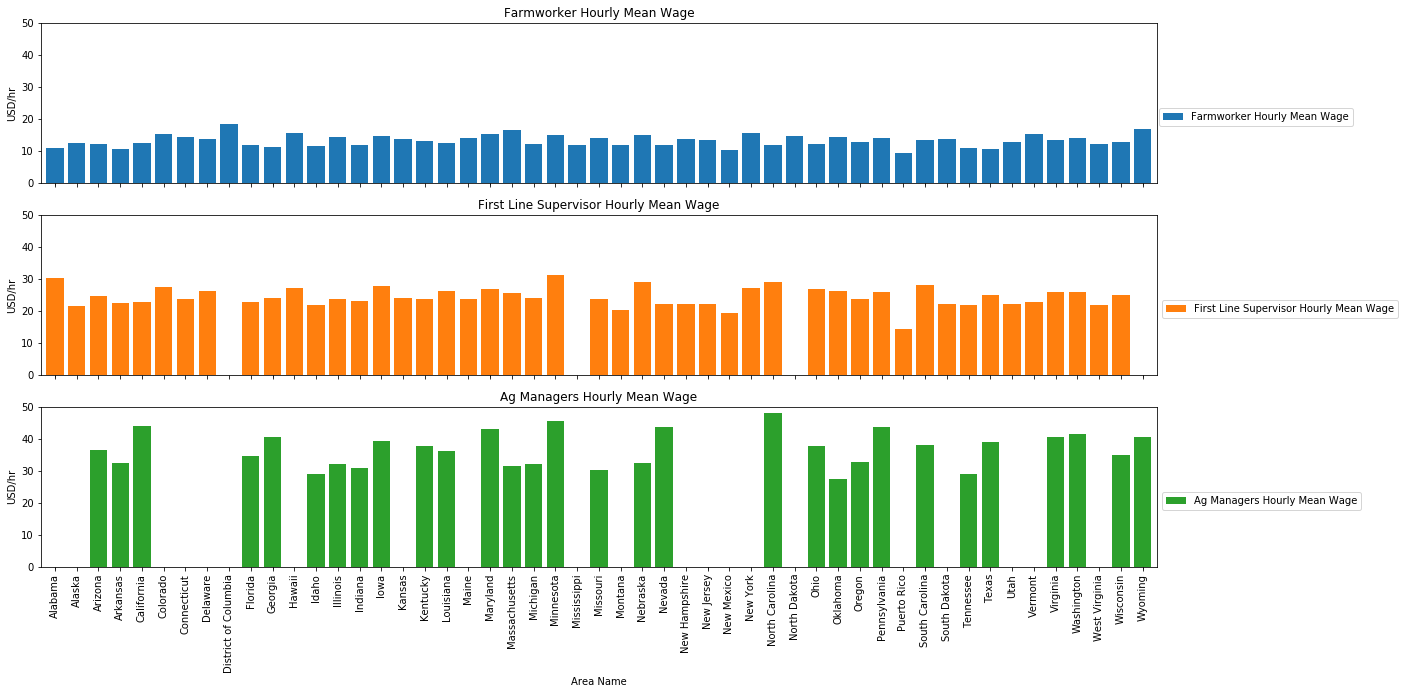

In [25]:
#Create combined unstyled bar plot for each occupation

#Farmworkers
ax = mean_wage.plot.bar(figsize = (20,10), width = 0.8, subplots = True)
leg1 = ax[0].legend(bbox_to_anchor = (1.18,0.5))
leg1.get_texts()[0].set_text('Farmworker Hourly Mean Wage')
ax[0].set_title('Farmworker Hourly Mean Wage')
ax[0].set_ylabel('USD/hr')
ax[0].set_ylim(0,50)

#First line supervisors
leg2 = ax[1].legend(bbox_to_anchor = (1,0.5))
leg2.get_texts()[0].set_text('First Line Supervisor Hourly Mean Wage')
ax[1].set_title('First Line Supervisor Hourly Mean Wage')
ax[1].set_ylabel('USD/hr')
ax[1].set_ylim(0,50)

#Agricultural managers
leg3 = ax[2].legend(bbox_to_anchor = (1,0.5))
leg3.get_texts()[0].set_text('Ag Managers Hourly Mean Wage')
ax[2].set_title('Ag Managers Hourly Mean Wage')
ax[2].set_ylabel('USD/hr')
ax[2].set_ylim(0,50)

**As expected farmworkers are earning the least and agricultural managers are earning the most. Now that we have this rough plot out of the way we can spend time making some much better graphics. Ideally we want to create plots that compare the living wage and the wage of each occupation.**

**Read in living wage data from scrape.**

In [0]:
#Read in living wage
living_wage_data = pd.read_csv('state_living_wages.csv', index_col = 0)

**Create function to depict barplots of the occupation wage and living wage for each state.**

In [0]:
def occupation_mean_wage_comparison(occupation):


  #Values for barplot (pccupation hourly wage)
  oc_mean_wage = mean_wage[str(occupation) + ' hourly mean wage'].values

  #Create subplot for fig, ax options
  fig, ax = plt.subplots(1, 1, figsize = (20,10))

  #Labels for x axis ticks
  states = mean_wage.index.values

  #Positions for xticks
  ind = np.arange(len(states))
  
  #Colors and unique labels
  if str(occupation) == 'Farmworker':
    color_choice = 'salmon'
    occupation_label = 'Farmworker'
    
  elif str(occupation) == 'First line supervisor':
    color_choice = 'powderblue'
    occupation_label = 'First Line Supervisor'
    
  else:
    color_choice = 'palegoldenrod'
    occupation_label = 'Ag Manager'
  
  #Plot bar plots
  Bars = ax.bar(ind, oc_mean_wage, align = 'center', color = color_choice, label = str(occupation_label) +' Hourly \nMean Wage')

  #Set and label the xticks
  ax.set_xticks(ind)
  ax.set_xticklabels(states, fontsize = 16, rotation = 90)

  #Set and label the yticks
  ax.set_ylim(0,50)
  ax.set_yticks([10, 20, 30, 40, 50])
  ax.set_yticklabels(['$10/hr','$20/hr','$30/hr','$40/hr', '$50/hr'], fontsize = 16)

  #Labels
  ax.set_title(str(occupation_label) + ' Hourly Mean Wage', size = 28)
  ax.set_ylabel('Hourly Wage (USD/hr)', size = 24, labelpad = 15)
  ax.set_xlabel('US State or Federal District', size = 24)

  #X coordinates for the horizontal lines
  x_start = np.array([plt.getp(item, 'x') for item in Bars])
  x_end = x_start+[plt.getp(item, 'width') for item in Bars]

  #Y coordinates of horizontal lines (living wages)
  targets = living_wage_data['2 Adults (1 Working) 1 Child'].values

  #Plot the horizontal lines using y coords
  plt.hlines(targets, x_start, x_end, label = 'Living Wage for 2 Adults \n(1 Working) and 1 Child')

  #Legend
  plt.legend(loc = 'best', prop = {'size':15})

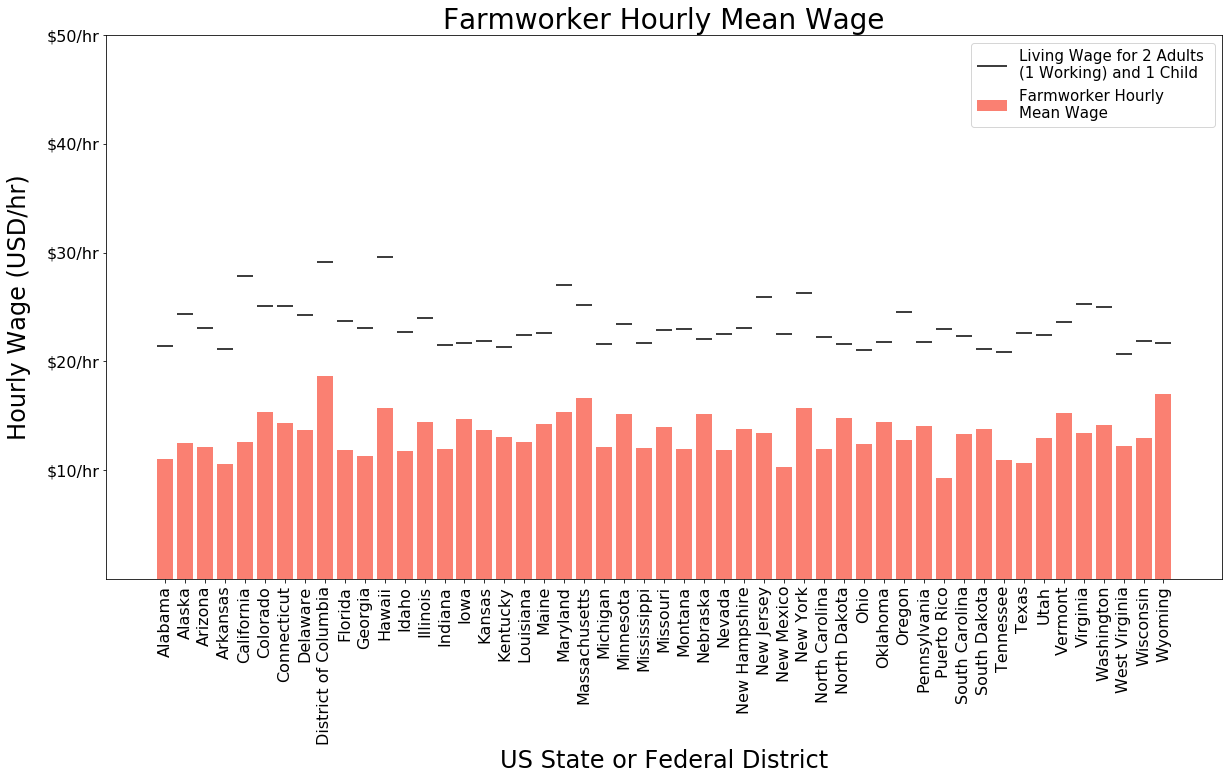

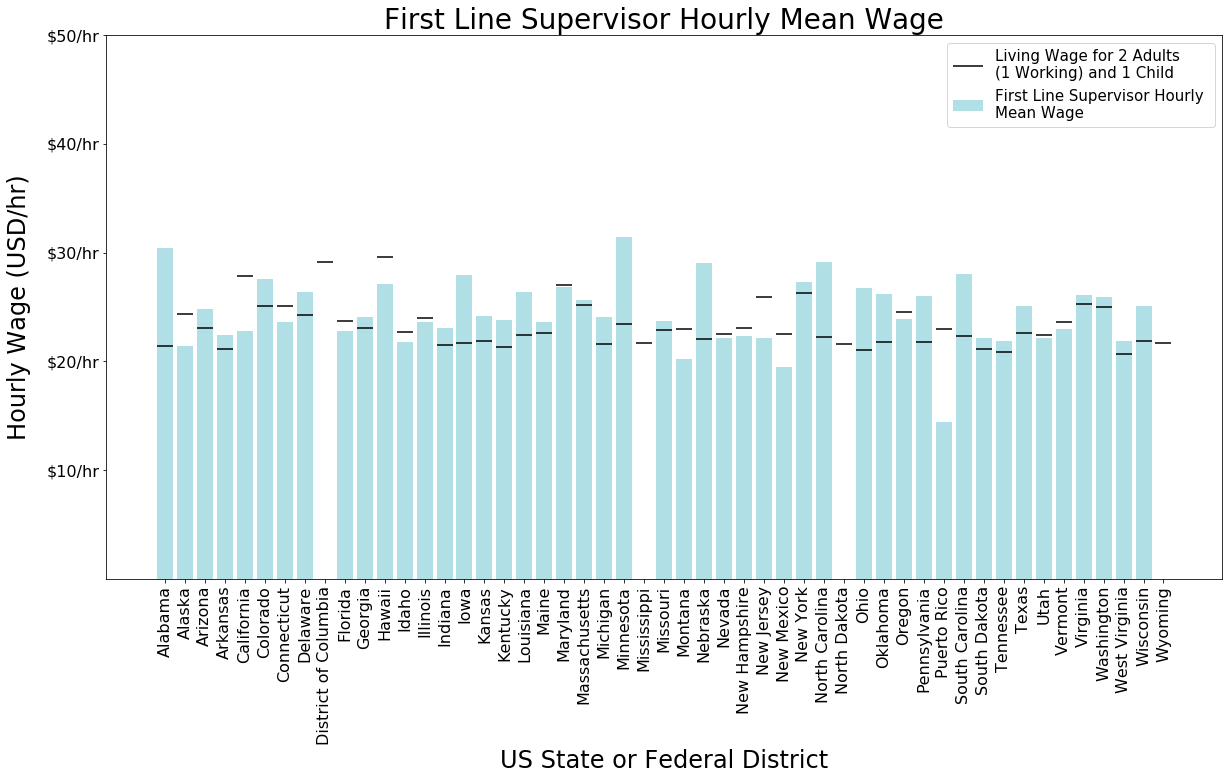

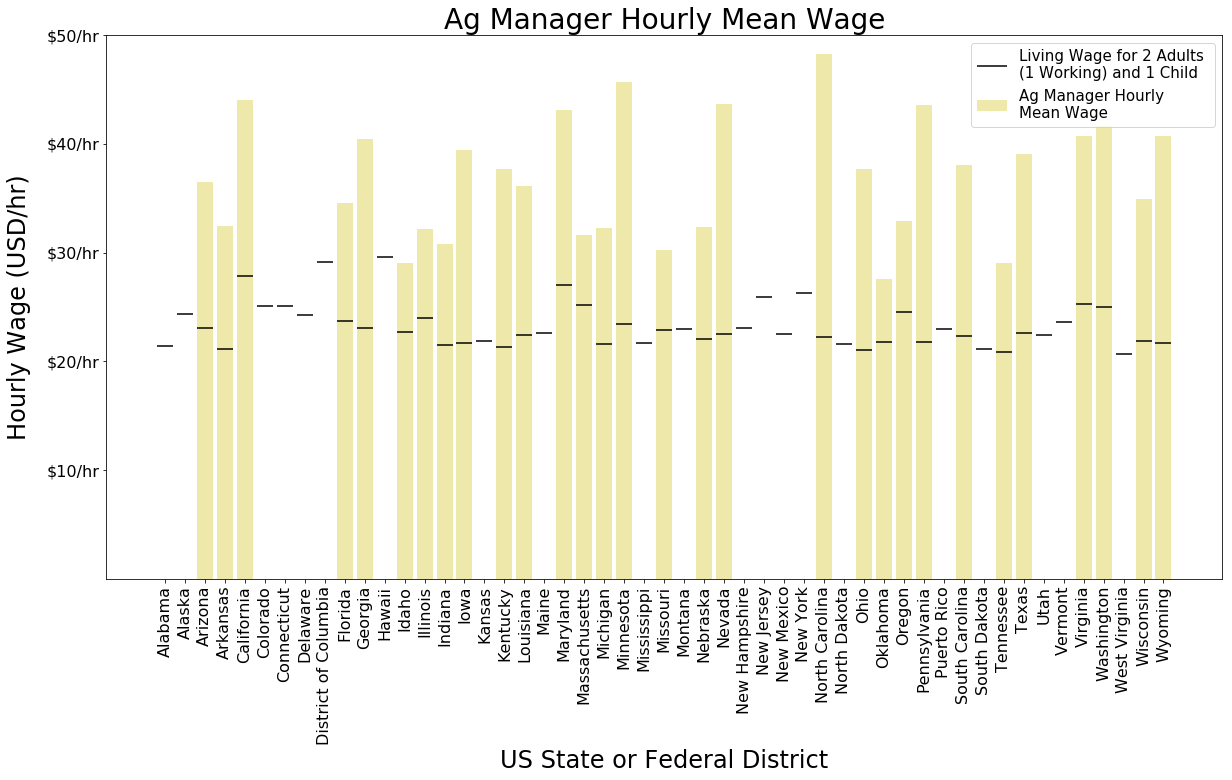

In [28]:
#Create plots for each occupation

occupations = ['Farmworker', 'First line supervisor', 'Ag managers']

for oc in occupations:
    occupation_mean_wage_comparison(oc)

**There are several key takeaways from the above three graphs. The first of which is that there are no states where the *mean* wage of farmworkers is greater than the living wage in a state. In fact, there are very few states where the living wage and the farmworkers occupation wage are even close. In contrast agricultural managers earn much more than the living wage in every state.**

**We will now make the same graphics using the median wage for each occupation.**

In [29]:
#Select only the median wages.
median_wage = wages[['Farmworker hourly median wage', 'First line supervisor hourly median wage', 'Ag managers hourly median wage']]
median_wage.head()

,Farmworker hourly median wage,First line supervisor hourly median wage,Ag managers hourly median wage
Area Name,,,
Alabama,10.73,28.59,NaN
Alaska,12.64,20.34,NaN
Arizona,11.11,23.90,27.73
Arkansas,9.70,22.11,29.41
California,11.65,19.75,37.95


In [0]:
def occupation_median_wage_comparison(occupation):


  #Values for barplot (pccupation hourly wage)
  oc_median_wage = median_wage[str(occupation) + ' hourly median wage'].values

  #Create subplot for fig, ax options
  fig, ax = plt.subplots(1, 1, figsize = (20,10))

  #Labels for x axis ticks
  states = median_wage.index.values

  #Positions for xticks
  ind = np.arange(len(states))
  
  #Colors and unique labels
  if str(occupation) == 'Farmworker':
    color_choice = 'salmon'
    occupation_label = 'Farmworker'
    
  elif str(occupation) == 'First line supervisor':
    color_choice = 'powderblue'
    occupation_label = 'First Line Supervisor'
    
  else:
    color_choice = 'palegoldenrod'
    occupation_label = 'Ag Manager'
  
  #Plot bar plots
  Bars = ax.bar(ind, oc_median_wage, align = 'center', color = color_choice, label = str(occupation_label) +' Hourly \nMedian Wage')

  #Set and label the xticks
  ax.set_xticks(ind)
  ax.set_xticklabels(states, fontsize = 16, rotation = 90)

  #Set and label the yticks
  ax.set_ylim(0,50)
  ax.set_yticks([10, 20, 30, 40, 50])
  ax.set_yticklabels(['$10/hr','$20/hr','$30/hr','$40/hr', '$50/hr'], fontsize = 16)

  #Labels
  ax.set_title(str(occupation_label) + ' Hourly Median Wage', size = 28)
  ax.set_ylabel('Hourly Wage (USD/hr)', size = 24, labelpad = 15)
  ax.set_xlabel('US State or Federal District', size = 24)

  #X coordinates for the horizontal lines
  x_start = np.array([plt.getp(item, 'x') for item in Bars])
  x_end = x_start+[plt.getp(item, 'width') for item in Bars]

  #Y coordinates of horizontal lines (living wages)
  targets = living_wage_data['2 Adults (1 Working) 1 Child'].values

  #Plot the horizontal lines using y coords
  plt.hlines(targets, x_start, x_end, label = 'Living Wage for 2 Adults \n(1 Working) and 1 Child')

  #Legend
  plt.legend(loc = 'best', prop = {'size':15})

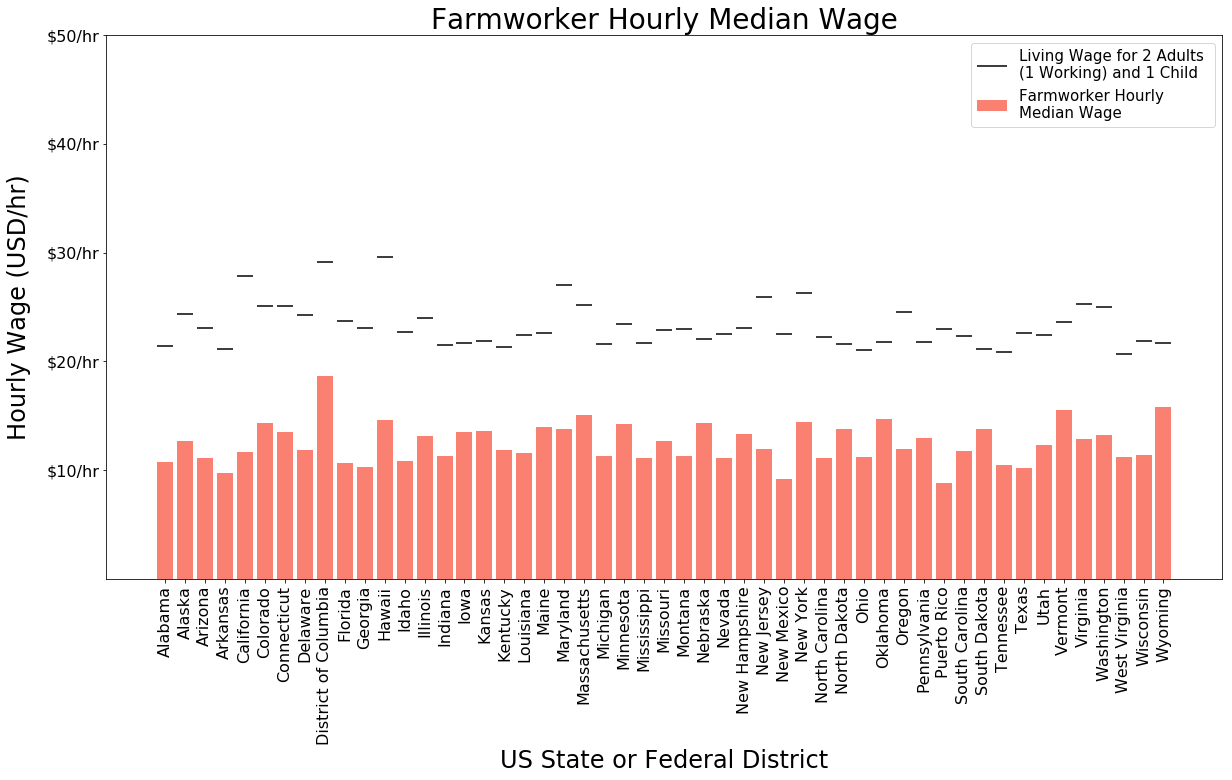

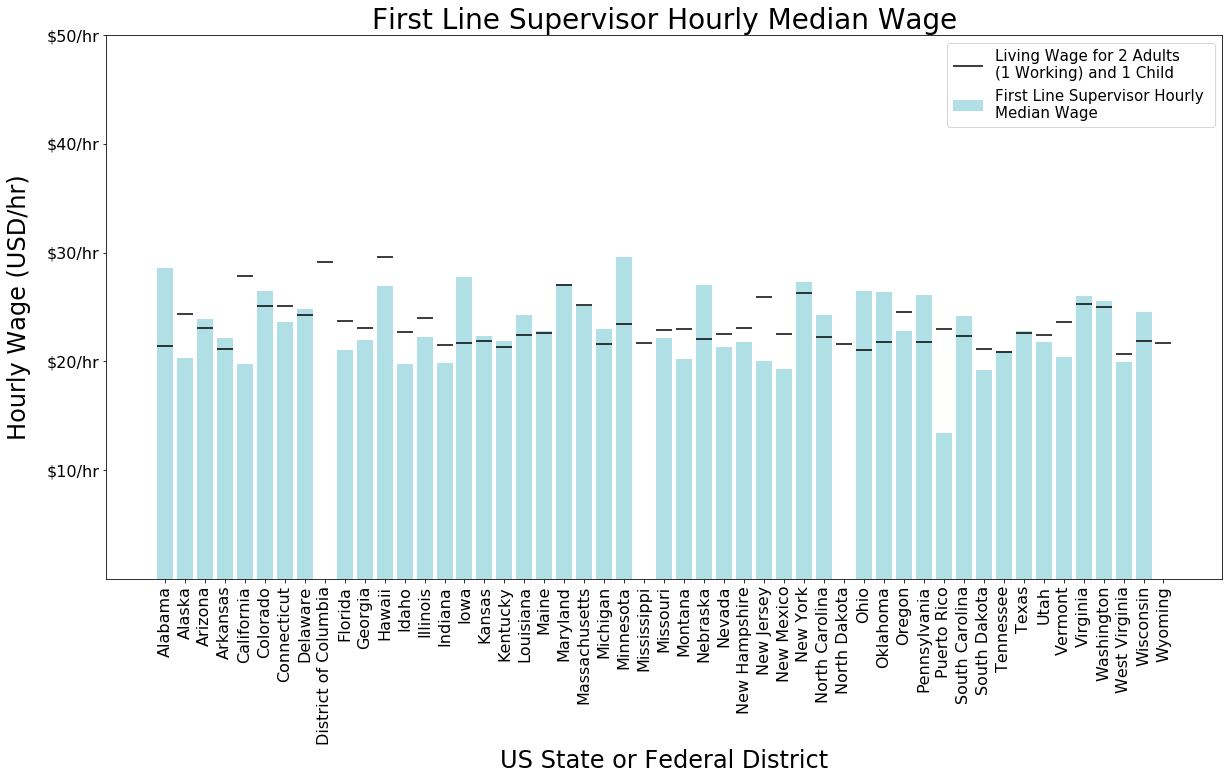

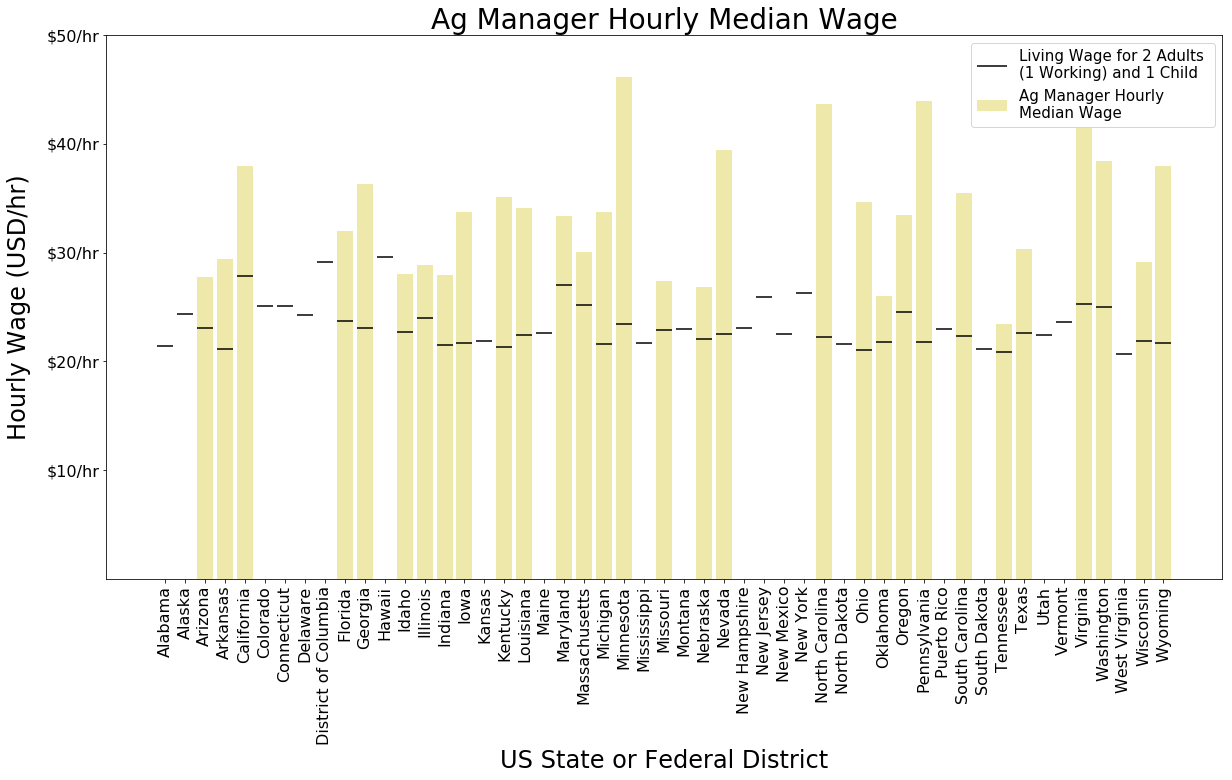

In [31]:
#Create plots for each occupation

occupations = ['Farmworker', 'First line supervisor', 'Ag managers']

for oc in occupations:
    occupation_median_wage_comparison(oc)

**The median graphs are somewhat simmilar to the mean graphs, although slightly more dire. In any case, we are confident that most farmworkers earn less than the living wage in every single state.**

# Wage Comparisons Between Occupations

It may be intersting to do some direct comparisons between the various agricultural occupations. We know there is a large discrepancy between them, but we can still find interesting ways to describe it.

**One interesting comparisons we can do is looking at the distributions of wages.**

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'State Mean Wages')

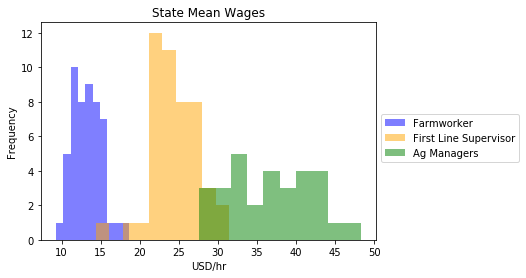

In [32]:
#Plot distribution of mean wages

#Create three histograms on the same figure
plt.hist(wages['Farmworker hourly mean wage'], color = 'blue', alpha = 0.5, label = 'Farmworker')
plt.hist(wages['First line supervisor hourly mean wage'], color = 'orange', alpha = 0.5, label = 'First Line Supervisor')
plt.hist(wages['Ag managers hourly mean wage'], color = 'green', alpha = 0.5, label = 'Ag Managers')

#Add a legend
plt.legend(bbox_to_anchor = (1, 0.6))

#Format axis labels
plt.ylabel('Frequency')
plt.xlabel('USD/hr')
plt.title('State Mean Wages')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'State Median Wages')

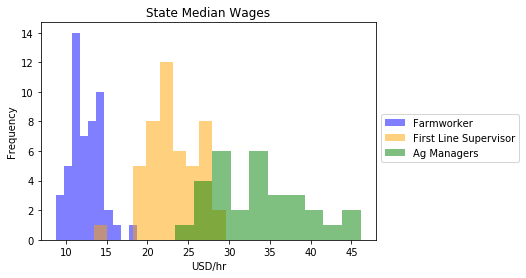

In [33]:
#Plot distribution of median wages

#Create three histograms on the same figure
plt.hist(wages['Farmworker hourly median wage'].values, color = 'blue', alpha = 0.5, label = 'Farmworker')
plt.hist(wages['First line supervisor hourly median wage'].values, color = 'orange', alpha = 0.5, label = 'First Line Supervisor')
plt.hist(wages['Ag managers hourly median wage'].values, color = 'green', alpha = 0.5, label = 'Ag Managers')

#Add a legend
plt.legend(bbox_to_anchor = (1, 0.6))

#Format axis labels
plt.ylabel('Frequency')
plt.xlabel('USD/hr')
plt.title('State Median Wages')

**When looking at the plot depicting the *mean* wages, we can see that there is some overlap between the occupations. We can interpret this as saying that a first line supervisor in state A makes more than an agricultural manager in state B. This is not really a meaningful comparison as it is between states, but it illustrates the nationwide variability. The plot depicting the *median* wage is quite interesting as the farmworker wages are, mostly, seperate from the other two occupations.**



---


**The next step we can take is looking at the ratios of wages between the three occupations in each state.**

In [34]:
#Calculate ratios

#Empty df
wages_comparison = pd.DataFrame()

#Populate df with ratios
wages_comparison['Farmworker to First Line Supervisor (median)'] = wages['Farmworker hourly median wage']/wages['First line supervisor hourly median wage']
wages_comparison['Farmworker to Ag Manager (median)'] = wages['Farmworker hourly median wage']/wages['Ag managers hourly median wage']

#For plotting
wages_comparison['Place Holder'] = list(range(0,510, 10))

#Inspect
wages_comparison.head()

,Farmworker to First Line Supervisor (median),Farmworker to Ag Manager (median),Place Holder
Area Name,,,
Alabama,0.375306,NaN,0
Alaska,0.621436,NaN,10
Arizona,0.464854,0.400649,20
Arkansas,0.438716,0.329820,30
California,0.589873,0.306983,40


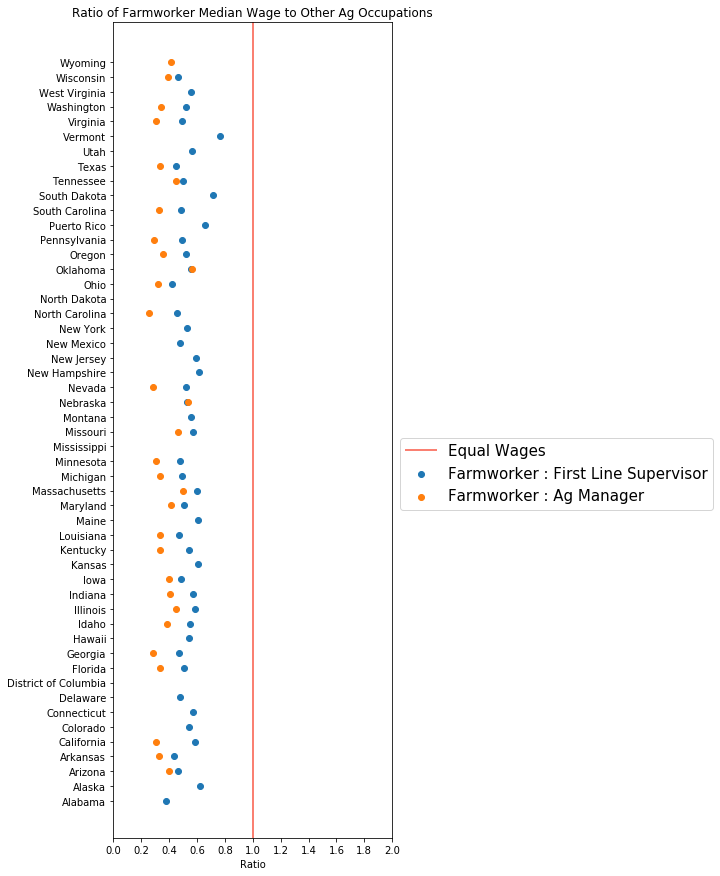

In [35]:
#Plot the ratios of farmworkers to the other two occupations by state

#Create figure
fig, ax = plt.subplots(figsize = (5,15))

#Plot components
ax.scatter(wages_comparison['Farmworker to First Line Supervisor (median)'], wages_comparison['Place Holder'], label = 'Farmworker : First Line Supervisor')
ax.scatter(wages_comparison['Farmworker to Ag Manager (median)'], wages_comparison['Place Holder'], label = 'Farmworker : Ag Manager')
ax.axvline(x = 1, lw =2, color = 'salmon', label = 'Equal Wages' )

#Set axis ticks and labels
ax.set_yticks(wages_comparison['Place Holder'])
ax.set_yticklabels(wages_comparison.index.values)

#Set up xticks
ind = np.linspace(0,2,11)
ax.set_xticks(ind)

#Set labels
ax.set_xlabel('Ratio')
ax.set_title('Ratio of Farmworker Median Wage to Other Ag Occupations')

#Legend
plt.legend(bbox_to_anchor = (1,0.5), prop = {'size':15})

**The above plot allows us to visualize the ratios of farmworker wages to the wages of the other two occupations. A ratio of one, which we do not expect, would mean that farmworkers make the same wage as the other occupation.**

**We can clean this visual up by just looking at the ratio of farmworker wages to ag manager wages.**

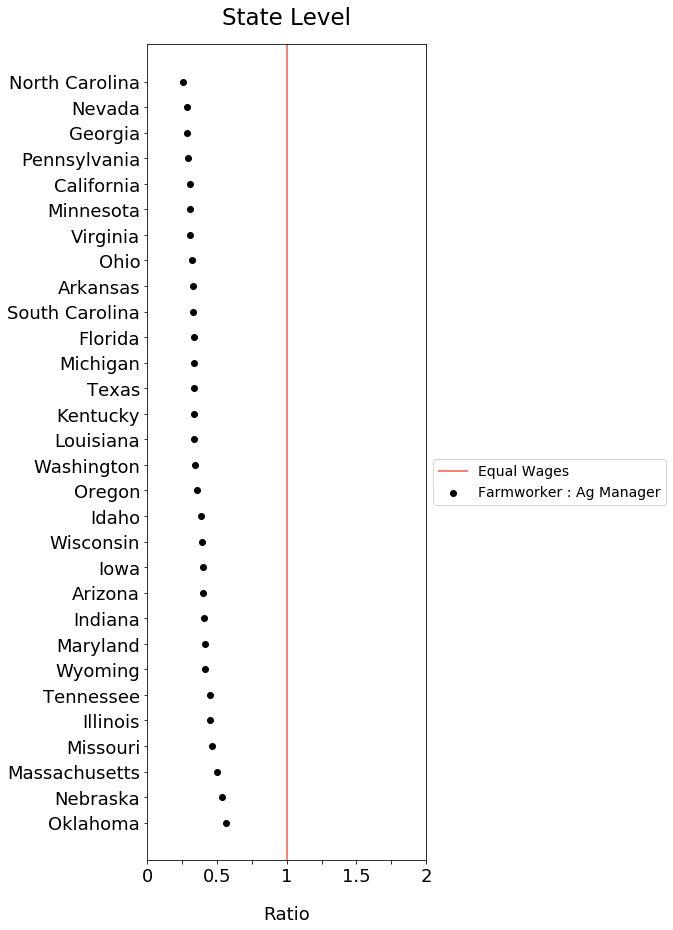

In [36]:
#Above scatter plot with only farmworker to ag manager ratio

#Create figure
fig, ax = plt.subplots(figsize = (5,15))

#Sort the ratios and remove nan values (some managers do not report their wages)
wages_comparison_sort = wages_comparison.sort_values(by = 'Farmworker to Ag Manager (median)', ascending = False)
wages_comparison_sort = wages_comparison_sort[~wages_comparison_sort['Farmworker to Ag Manager (median)'].isnull()]

#Plot components
ax.scatter(wages_comparison_sort['Farmworker to Ag Manager (median)'], np.arange(wages_comparison_sort.shape[0]), color = 'black', label = 'Farmworker : Ag Manager')
ax.axvline(x = 1, lw =2, color = 'salmon', label = 'Equal Wages' )

#Set axis ticks and labels
ax.set_yticks(np.arange(wages_comparison_sort.shape[0]))
ax.set_yticklabels(wages_comparison_sort.index.values, fontsize = 18)

#xtick formatting
ax.set_xticks(np.linspace(0,2,9))
ax.set_xticklabels([0," ",0.50," ",1," ",1.50," ",2], fontsize = 18)

#Set labels
ax.set_xlabel('Ratio', fontsize = 18, labelpad = 20)
ax.set_title('State Level', pad = 20, fontsize = 23)

#Legend
plt.legend(bbox_to_anchor = (1,0.5), prop = {'size':14})

**Now we can clearly see that there are some states where farmworkers make only a quarter the wages of agricultural managers!**

**We can do a simmilar analysis on the national level. When looking at the national level data it is important not to forget the variability from state to state that we just saw.**

Text(0.5, 1.0, 'National Level')

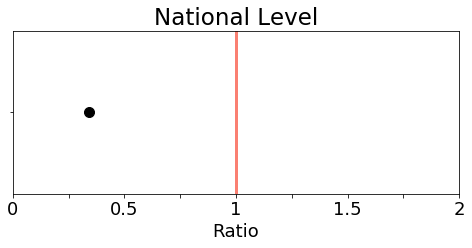

In [37]:
fig, ax = plt.subplots(figsize = (8,3))

#Scatter plot but combine all states
mean_states = wages_comparison['Farmworker to Ag Manager (median)'].median()

#Plot components
ax.scatter(mean_states, 5, label = 'Farmworker : Ag Manager', color = 'black', s = 100)
ax.axvline(x = 1, lw =3, color = 'salmon', label = 'Equal Wages' )

#Set axis ticks and labels
ax.set_yticks([5])
ax.set_yticklabels([''])

ax.set_xticks(np.linspace(0,2,9))
ax.set_xticklabels([0," ",0.50," ",1," ",1.50," ",2], fontsize = 18)

#Set labels
ax.set_xlabel('Ratio', fontsize = 18)
ax.set_title('National Level', fontsize = 23)

**When looking at the median ratio from all the states, farmworkers earn about 1/3 of an agricultural manager's wage.**

# Mapping Data

We can use the living wage data and the median wages of agricultural occupations to create some figures. The following figures were constructed using QGIS.

**A good comparison would be looking at the median wage of each occupation as a percent of the living age in each state.**

In [38]:
#Select living wages data for 2 Adults (1 Working) 1 Child
living_wage_scenario = living_wage_data[['2 Adults (1 Working) 1 Child']]


median_wage = wages[['Farmworker hourly median wage', 'First line supervisor hourly median wage', 'Ag managers hourly median wage']]
#Select occupation median wages
median_wages = wages[['Farmworker hourly median wage', 'First line supervisor hourly median wage', 'Ag managers hourly median wage']]

#Merge living wage and occupation wage data
living_wage_scenario = living_wage_scenario.merge(median_wage, left_index = True, right_index = True)
living_wage_scenario.index.name = 'State'

#Occupations of interest
occupation_wages = ['Farmworker hourly median wage', 'Ag managers hourly median wage']

#Find the percent of the living wage earned by the median wage in each state
for i in occupation_wages:
  living_wage_scenario[i+' Living Difference'] = living_wage_scenario[i] - living_wage_scenario['2 Adults (1 Working) 1 Child']
  living_wage_scenario[i+' as percent of living wage'] = (living_wage_scenario[i]/living_wage_scenario['2 Adults (1 Working) 1 Child'])*100

#Save as csv for QGIS Analysis
living_wage_scenario.to_csv('living_wage_mapping.csv', index_label ='State')

#Inspect
living_wage_scenario.head()

,2 Adults (1 Working) 1 Child,Farmworker hourly median wage,First line supervisor hourly median wage,Ag managers hourly median wage,Farmworker hourly median wage Living Difference,Farmworker hourly median wage as percent of living wage,Ag managers hourly median wage Living Difference,Ag managers hourly median wage as percent of living wage
State,,,,,,,,
Alabama,21.37,10.73,28.59,NaN,-10.64,50.210576,NaN,NaN
Alaska,24.33,12.64,20.34,NaN,-11.69,51.952322,NaN,NaN
Arizona,23.09,11.11,23.90,27.73,-11.98,48.116068,4.64,120.095279
Arkansas,21.14,9.70,22.11,29.41,-11.44,45.884579,8.27,139.120151
California,27.87,11.65,19.75,37.95,-16.22,41.801220,10.08,136.167922


![alt text](https://docs.google.com/uc?export=download&id=1Iv8UH4wC5wclGWX-KGb8iir2Na5SRQV-)


![alt text](https://docs.google.com/uc?export=download&id=10TYz-dlxJdF3QPu2G9714c8sQXFg0qGk)

Black colored states did not report the median wage of agricultural managers to the BLS.

**The above figures demonstrate that it is not possible to earn the median wage of a farmworker in a state and earn the living wage in the same state. Some states like California and New Mexico are particularly bad. In contrast, the median wage of agricultural managers allows them to earn more than the living wage. In some cases, agricultural managers earn twice as much as the living wage. Given this analysis, it is important to target support for the agricultural industry toward those that actually are in need of it. Broad brushed actions will be inefficient.**